In [10]:
import csv
import cv2
import numpy as np
import sklearn

# Analyzing Data

Extract csv data and then retreive images from the appropriate path.

In [11]:
samples = []
csv_path = 'data/driving_log.csv'
print('Retreiving data from {}'.format(csv_path))   
with open(csv_path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
del samples[0]

Retreiving data from data/driving_log.csv


In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

samples = shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('Number of train samples: {}'.format(len(train_samples)))
print('Number of validation samples: {}'.format(len(validation_samples)))

Number of train samples: 6428
Number of validation samples: 1608


In [33]:
def generator(samples, batch_size=32, training=True):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                # Choose camera sample randomly center, left, or right
                if training:
                    camera_source = np.random.randint(0, 3)
                else:
                    camera_source = 0
                name = 'data/IMG/'+batch_sample[camera_source].split('/')[-1]
                image = cv2.imread(name)
                angle = float(batch_sample[3])
                # Make angle correction
                if camera_source == 1:
                    angle = angle + 0.2
                if camera_source == 2:
                    angle = angle - 0.2
                # Flip image randomly
                if training  and np.random.rand() > 0.5:
                    image = np.fliplr(image)
                    angle = -angle
                images.append(image)
                angles.append(angle)
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [45]:
train_generator = generator(train_samples)
validation_generator = generator(validation_samples, training=False)

In [46]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))


In [47]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=32000,
                    validation_data=validation_generator, 
                    nb_val_samples=len(validation_samples), nb_epoch=5)

Epoch 1/5
31984/32000 [============================>.] - ETA: 0s - loss: 0.0202   

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


32016/32000 [==============================] - 318s - loss: 0.0202 - val_loss: 0.0140
Epoch 2/5
32012/32000 [==============================] - 318s - loss: 0.0170 - val_loss: 0.0132

dict_keys(['loss', 'val_loss'])


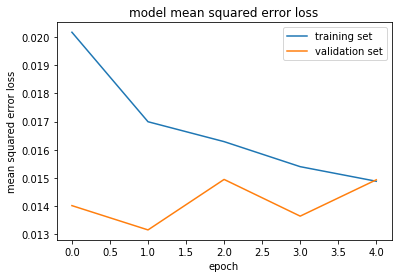

In [48]:
from keras.models import Model
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [49]:
import json

model.save('model.h5')
model.save_weights('model_weights.h5')
with open('model.json', 'w') as modelfile:
    json.dump(model.to_json(), modelfile)